# Using HuggingFace and PyTorch Lightning for multi-label text classification - 02 - exp-01-01

Revision: 1.00

Date: $20^{th}. May, 2021$

Author: Anshul Verma

PyTorch Lightning to Pytorch is like keras to tensorflow, and it makes job easy.

In [ ]:
!nvidia-smi

Sun May 30 22:08:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pytorch-lightning==1.3.2 transformers==4.6.1

     |████████████████████████████████| 808kB 7.5MB/s 
     |████████████████████████████████| 2.3MB 15.8MB/s 
     |████████████████████████████████| 645kB 49.0MB/s 
     |████████████████████████████████| 276kB 53.2MB/s 
     |████████████████████████████████| 10.6MB 50.8MB/s 
     |████████████████████████████████| 829kB 51.2MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 
     |████████████████████████████████| 901kB 47.7MB/s 
     |████████████████████████████████| 1.3MB 36.1MB/s 
     |████████████████████████████████| 143kB 53.0MB/s 
     |████████████████████████████████| 296kB 53.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=66cc0c7bdc039b0debc55d54057f4e928ffa3eefcf1b640d3405dd80db19116f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement te

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 2021
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 8
pl.seed_everything(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Global seed set to 2021


#### Mount the google drive and load the scraped data

we have a column called category in the  dataframe which is what we will consider to be the final class after removing the sub-categories for now.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Saving the final dataframe

In [ ]:
#df.to_csv('drive/MyDrive/arXiv/final_df.csv', index=False)
df = pd.read_csv('drive/MyDrive/arXiv/final_df.csv')
major_topics = ['math', 'stat', 'physics', 'q-bio', 'q-fin']

Now lets split the dataset into `train`, `test` and `validation` datasets. (80-10-10 **split**)

In [ ]:
train_df, val_df = train_test_split(df, test_size = 0.2, shuffle=True, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size = 0.5, shuffle=True, random_state=RANDOM_SEED)

print(f'Number of training samples: {len(train_df)}')
print(f'Number of validation samples: {len(val_df)}')
print(f'Number of test samples: {len(test_df)}')

Number of training samples: 32000
Number of validation samples: 4000
Number of test samples: 4000


In [ ]:
print(f'LABEL_COLUMNS : {major_topics}')

LABEL_COLUMNS : ['math', 'stat', 'physics', 'q-bio', 'q-fin']


Seeing the distribution in different splits

In [ ]:
print(f' train split: {train_df[major_topics].sum()}')
print(f'\n val split: {val_df[major_topics].sum()}')
print(f'\n test split: {test_df[major_topics].sum()}')

 train split: math       12680
stat        7539
physics     9227
q-bio       6780
q-fin       6586
dtype: int64

 val split: math       1583
stat        947
physics    1122
q-bio       810
q-fin       824
dtype: int64

 test split: math       1574
stat        970
physics    1085
q-bio       824
q-fin       855
dtype: int64


Looks like the classes are evenly spread in all the dataframes therefore not stratifying any thing in split and continuing. Lets start by using a pre-trained tokenizer. 

## Approach - 1 Classifying using Title only

### Using a pretrained bert-tokenizer (Uncased)

We have CASED and UNCASED options for the BERT model, case-sensitivity for a topic should not affect the topic it belongs to and hence I will use the UNCASED version of BERT tokenizer, for the first model I will use a pretrained tokenizer (but it will ofcourse miss a lot of scientific-terms, because BERT was not trained on scientific languages), I am intensionally doing this for the first attempt so that I can see the effect of training the tokenizer the second time. Keeping in mind most of the titles have under **30 words**, considering some plural words and the average token length should be `<40`. Therefore encoding titles to **40 words**.

In [ ]:
BERT_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Lets just see how this encoder works by encoding a sample from training dataframe.

In [ ]:
sample_row = train_df.iloc[RANDOM_SEED]
sample_title = sample_row.title
sample_labels = sample_row[major_topics]

# encode this sample comment
encoding = tokenizer.encode_plus(
    sample_title,
    add_special_tokens=True,
    max_length=40,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt" # return tensor in pytorch format
)
print(f"Things contained by this encoding {encoding.keys()}")
'''
Inputs to the model these input-ids contains IDs of the tokens
whereas attention masks is 1-0 depending if the token is missing(0) or not
'''
print(f"\ninput_ids shape: {encoding['input_ids'].shape}, attention_mask shape: {encoding['attention_mask'].shape}")

Things contained by this encoding dict_keys(['input_ids', 'attention_mask'])

input_ids shape: torch.Size([1, 40]), attention_mask shape: torch.Size([1, 40])


Lets just see how the title is getting tokenized

In [ ]:
print(f"Title: {sample_title}")
print(f"Tokenized(first 20): {tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze()[:20])}")

Title: intracellular microrheology of motile amoeba proteus
Tokenized(first 20): ['[CLS]', 'intra', '##cellular', 'micro', '##rh', '##eo', '##logy', 'of', 'mo', '##tile', 'am', '##oe', '##ba', 'pro', '##te', '##us', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


#### Ahaannn!!! we can see the stop words still exisitng and all the tokens are the ones used in training the BERT-model.

Lets create the dataset.

In [ ]:
class arXivTitleCategoryDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 40, 
               x_col: str="title", major_topics: list=["math", "stat", "physics", "q-bio", "q-fin"]):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.x_col = x_col
    self.label_classes = major_topics

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = df.iloc[index]
    title = data_row[self.x_col]
    labels = data_row[self.label_classes].values.tolist()

    encoding = self.tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True, # make sure that each sequence is of max_token_len
        return_attention_mask=True,
        return_tensors="pt" #to return tensors like pytorch
    )

    return dict(
        title=title,
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        labels=torch.FloatTensor(labels) # required by the loss function
    )

Defining the dataset using the class defined above.

In [ ]:
# using the pretrained tokenzier and defining the dataset
train_dataset = arXivTitleCategoryDataset(train_df, tokenizer)
val_dataset = arXivTitleCategoryDataset(val_df, tokenizer)
test_dataset = arXivTitleCategoryDataset(test_df, tokenizer)

Lets sample a point of the training dataset and the prediction from a pretrained Bert-Model on it.

In [ ]:
sample_item= train_dataset[22]
print(f"keys of the sample-item {sample_item.keys()}")

keys of the sample-item dict_keys(['title', 'input_ids', 'attention_mask', 'labels'])


Lets load the model and try and make a prediction.

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) # returns a data-class

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lets make a prediction without training anything or fine-tuning

In [ ]:
prediction = bert_model(sample_item["input_ids"].unsqueeze(dim=0), sample_item["attention_mask"].unsqueeze(dim=0))
prediction.last_hidden_state.shape, prediction.pooler_output.shape # input and hidden-state, pooling operation

(torch.Size([1, 40, 768]), torch.Size([1, 768]))

In [ ]:
class arXivTitleCategoryModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=16, max_token_len=40):
    super().__init__()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = arXivTitleCategoryDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )    

    self.val_dataset = arXivTitleCategoryDataset(
        self.val_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = arXivTitleCategoryDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2 # feed more than one batch at a time
    )
  
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2 # feed more than one batch at a time
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2 # feed more than one batch at a time
    )


Lets setup the data-module

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 32

data_module = arXivTitleCategoryModule(train_df, val_df, test_df, tokenizer, batch_size=BATCH_SIZE)
data_module.setup()

## Modeling

### Evaluation 

We are going to use binary-cross-entropy loss because we want to achieve multi-calss classification (categorical-cross-entropy for single-label classification with multiple labels). How much each of the possible class in the sample is correct. (**BCELoss** -> targes should be between 0 and 1, we can add label smoothing later and check its status)

Pass the input-tensor to the **BCELoss** through a `sigmoid` and so that output value for each class becomes a probability of the input belonging to that class and we can have total probability > 1 since we are not using `softmax` and max probability of class as 1. (Allowing us to have multi-label classification)

**BCEWithLogitsLoss** -> combines the `sigmod` with the **BCELoss** so that we dont manually need to pass the input tensor to the loss through a `sigmoid`. Not using this becuase if we use this loss then to predicts the labels of a test input we will need to pass the output tensor of that input through sigmoid (which is not ideal, additional *activation* layer for final prediction), although BCEWithLogitsLoss is numerically stable so it might be useful in some cases.


In [ ]:
criterion = nn.BCELoss()

class arXivTitleClassifier(pl.LightningModule):
  def __init__(self, n_classes: int=5, steps_per_epoch: int=None, n_epochs: int=None,
               BERT_MODEL_NAME: str="bert-base-uncased",
               LABEL_COLUMNS: list=["math", "stat", "physics", "q-bio", "q-fin"]):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # hidden size for bert is 768
    self.LABEL_COLUMNS = LABEL_COLUMNS
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    '''
      Compute loss in the forward step if labels are given
      (Standard in fine-tuning bert)
    '''
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output
    
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return {"val_loss": loss} 

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    self.labels = batch["labels"]
    loss, self.outputs = self(input_ids, attention_mask, self.labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return {"test_loss": loss, "test_predictions": self.outputs, "test_labels": self.labels}

  def training_epoch_end(self, outputs):
    '''
      Computing ROC-AUC score for the prediction at the end of training
    '''
    labels = []
    predictions = []
    for output in outputs:
      # detach from CPU because we are training using GPU
      for output_labels in output["labels"].detach().cpu():
        labels.append(output_labels)
      
      for output_predictions in output["predictions"].detach().cpu():
        predictions.append(output_predictions)
    
    labels = torch.stack(labels).detach().cpu()
    predictions = torch.stack(predictions).detach().cpu()
    # per class AUC-ROC score because we are doing multilabel classification 
    # its like a binary classification for all the classes
    for i, name in enumerate(self.LABEL_COLUMNS):
      roc_score = auroc(preds=predictions[:, i], target=labels[:, i].type('torch.IntTensor'))
      # adding results to tensorboard
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", roc_score, self.current_epoch)

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5) # original recommended fine-tune lr from bert-paper
    
    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )
  
  def predict(self, batch, batch_idx: int , dataloader_idx: int = None):
    return self(batch)

## Training 
Lets train the model 

In [ ]:
model = arXivTitleClassifier(
    n_classes=len(major_topics),
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    n_epochs = N_EPOCHS,
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lets see how the predictions will look like without training just to ensure everything is correct with the model

In [ ]:
_, prediction = model(
    sample_item["input_ids"].unsqueeze(dim=0),
    sample_item["attention_mask"].unsqueeze(dim=0),
)
print(prediction)

tensor([[0.5848, 0.4714, 0.4691, 0.4276, 0.7200]], grad_fn=<SigmoidBackward>)


Great its the prediction probability of a sample beloging to each class ofcourse the model has not been fin-tuned yet so its jardon right now but the format is currect and we can go ahead and train or fine-tune the model.

Lightning makes it easy to train by defining the trainer, definining a non-essential callback for a trainer and trainer

In [ ]:
resume_from_checkpoint = "drive/MyDrive/arXiv/model/checkpoint-exp-01-01/last.ckpt"

trainer = pl.Trainer(default_root_dir="drive/MyDrive/arXiv/model/",
                     max_epochs=N_EPOCHS, gpus=1, progress_bar_refresh_rate=30,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3),
                                ModelCheckpoint(
                                    dirpath ="drive/MyDrive/arXiv/model/checkpoint-01-01/",
                                    filename="bert",
                                    monitor="val_loss", 
                                    mode="min", 
                                    save_last=True, 
                                    period=1, 
                                    save_top_k=1
                                )])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.944   Total estimated model params size (MB)


Global seed set to 2021


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


## Lets see the training results in tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "drive/MyDrive/arXiv/model/lightning_logs-exp-01-01/"

Reusing TensorBoard on port 6006 (pid 1189), started 0:00:03 ago. (Use '!kill 1189' to kill it.)

<IPython.core.display.Javascript object>

## Lets see the test result now

In [ ]:
loss = trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.008159241639077663}
--------------------------------------------------------------------------------


## Summary

We can see that the loss is still at **0.56** and the best `ROC-AUC` that a class could attend was **0.62**. This is not great considering the complexity of the model.

I am pretty certain that the reason for this poor-performace is using a BERT-tokenizer on scientific paper's title. It must have missed a lot of words.

exp-01-02 will be training the tokenizer on the abstract and title of the papers and then use that tokenizer to encode the inputs and then train the model.

## Detailed analysis

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import hamming_loss, accuracy_score, f1_score

In [ ]:
trained_model = arXivTitleClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(major_topics)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
max_token_len = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []

test_dataset = arXivTitleCategoryDataset(
  test_df,
  tokenizer,
  max_token_len=max_token_len
)

for i, item in enumerate( tqdm(test_dataset) ):
  if i < len(test_df):
    _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())
  else:
    break

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
P_threshold = 0.5
one_hot_predictions = np.array([(p.numpy() > P_threshold).astype('int32') for p in predictions])
one_hot_labels = labels.numpy()

In [ ]:
accuracy = (one_hot_labels == one_hot_predictions).sum()/(len(one_hot_labels)*len(one_hot_labels[0]))
print(f'Binary Accruacy of the model is: {accuracy*100}%')

Binary Accruacy of the model is: 99.83999999999999%


In [ ]:
hamming_loss_ = hamming_loss(one_hot_labels, one_hot_predictions)
f1_macro = f1_score(one_hot_labels, one_hot_predictions, average='macro')
f1_weighted = f1_score(one_hot_labels, one_hot_predictions, average='weighted')
f1_scores = f1_score(one_hot_labels, one_hot_predictions, average=None)
print(f'Hamming loss of the model is {hamming_loss_}')
print(f'F1-macro score of the model is {f1_macro}')
print(f'F1-weighted score of the model is {f1_weighted}')
print(f"Per class F1-score of the model is {[f'{class_}: {score}' for class_, score in zip(major_topics, f1_scores)]}")

Hamming loss of the model is 0.0016
F1-macro score of the model is 0.9306833221372639
F1-weighted score of the model is 0.996049400096013
Per class F1-score of the model is ['math: 0.9993746091307067', 'stat: 0.9649122807017544', 'physics: 0.8533333333333333', 'q-bio: 0.9047619047619047', 'q-fin: 0.9310344827586207']


It is evident to see that the model is not learnig abything about `q-bio`, `q-fin` and `stat`. Maybe because the terms in their title are ignored more when encoded with a pretrained tokenizer. Should definetly attempt to train the tokenizer or use a relevant tokenizer.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


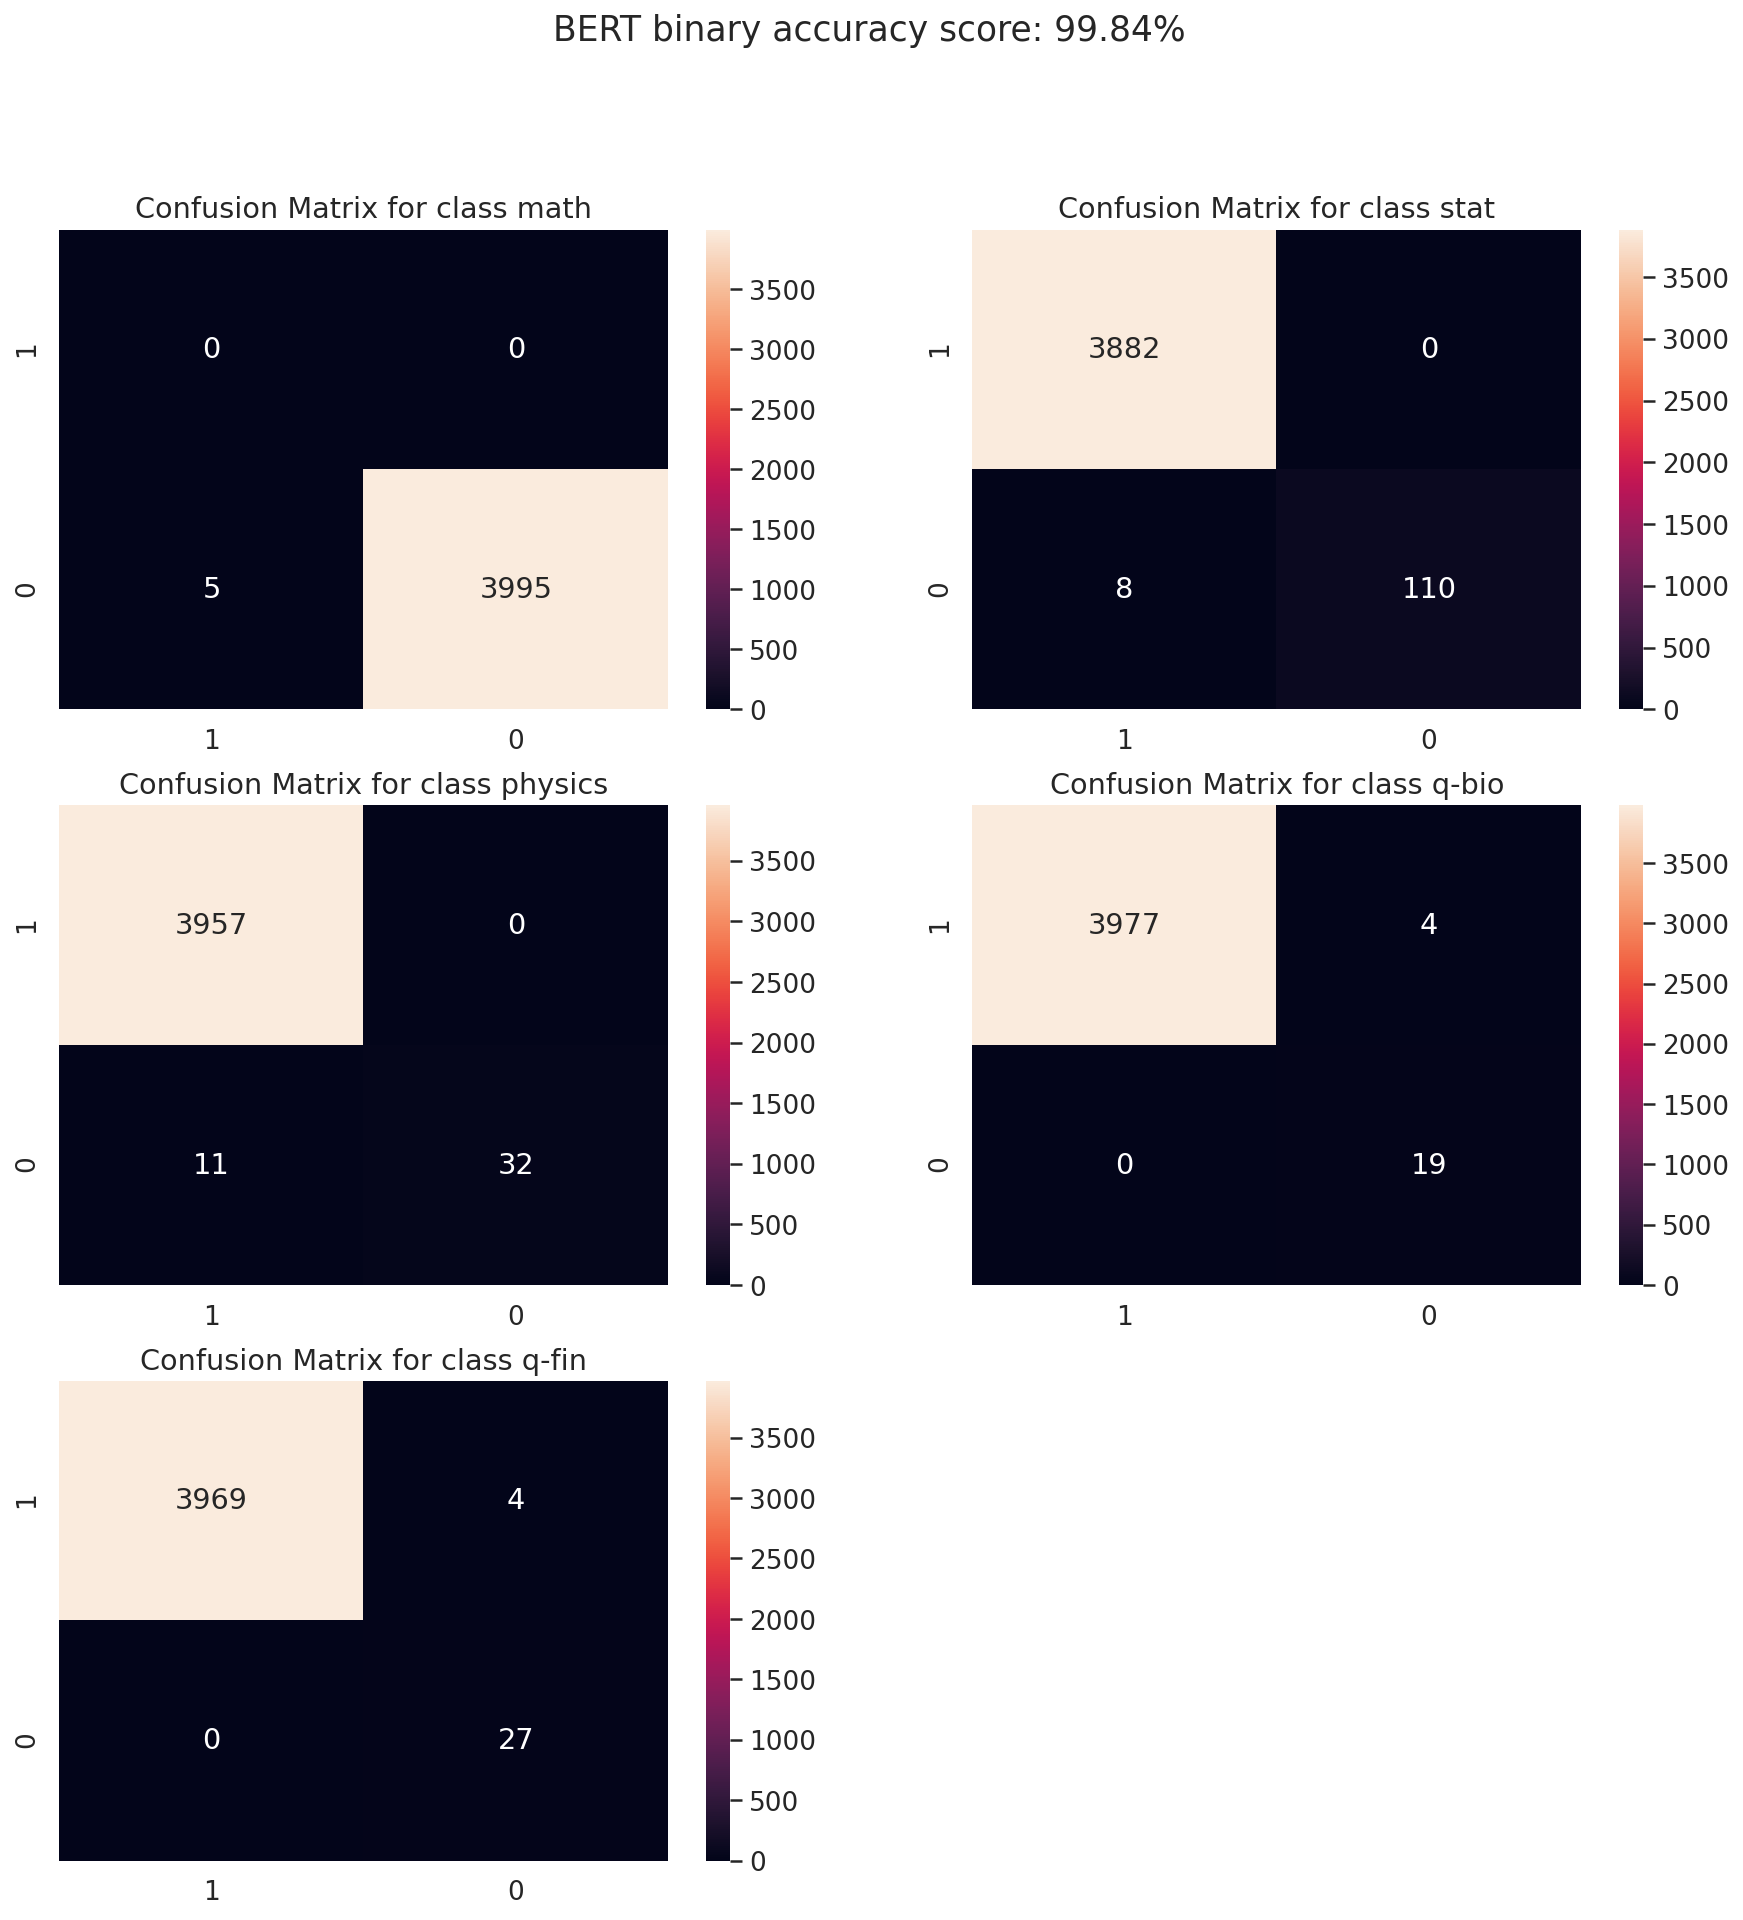

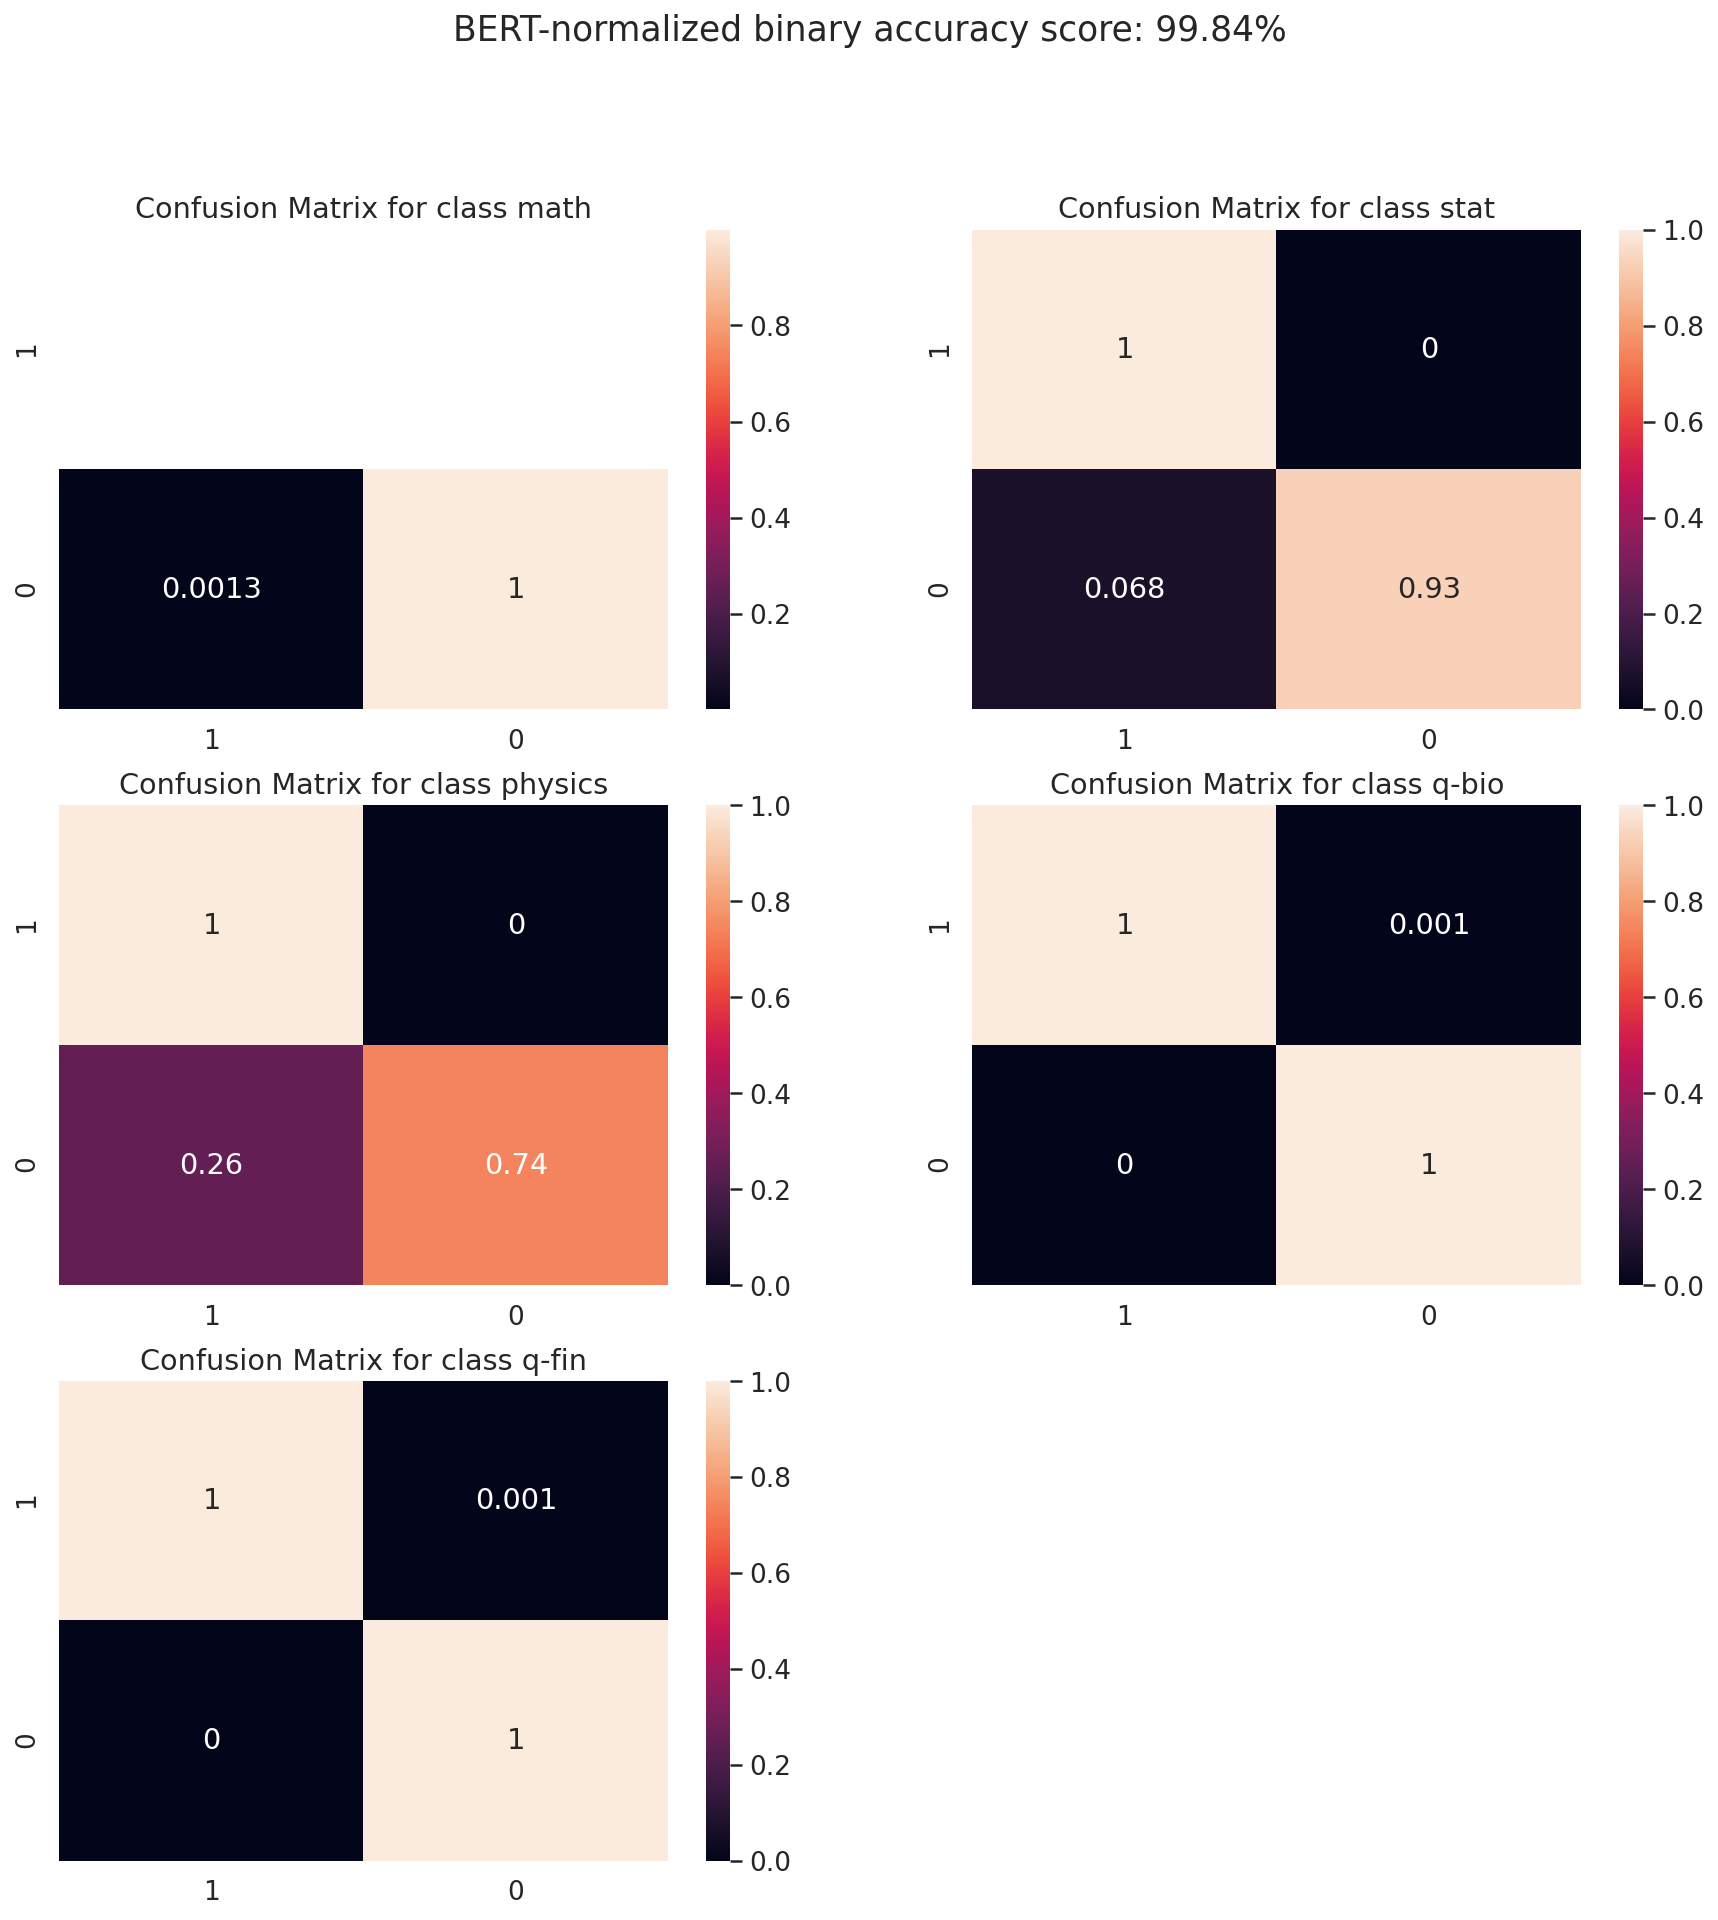

In [39]:
multilabel_CMs = multilabel_confusion_matrix(one_hot_labels, one_hot_predictions)
norm_multilabel_CMs = np.array([(CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]) for CM in multilabel_CMs])
fig=plt.figure(figsize=(15, 15))
import math
import os
rows = int(math.ceil(len(major_topics)/2))
for i, CM in enumerate(multilabel_CMs):
    axes = fig.add_subplot(rows, 2, i+1)
    df_cm = pd.DataFrame(CM, index=[i for i in [1, 0]],
                          columns=[i for i in [1, 0]])
    sns.heatmap(df_cm, annot=True, ax=axes, fmt='d')
    axes.set_title(f'Confusion Matrix for class {major_topics[i]}')
fig.suptitle('{} binary accuracy score: {:.2f}%'.format('BERT', accuracy*100))
plt.savefig(os.path.join("drive/MyDrive/arXiv/model", f"exp_01_01_multilabel_CM.png"))
plt.show()
plt.close()

fig=plt.figure(figsize=(15, 15))
for i, CM in enumerate(norm_multilabel_CMs):
    axes = fig.add_subplot(rows, 2, i+1)
    df_cm = pd.DataFrame(CM, index=[i for i in [1, 0]],
                          columns=[i for i in [1, 0]])
    sns.heatmap(df_cm, annot=True, ax=axes)
    axes.set_title(f'Confusion Matrix for class {major_topics[i]}')
fig.suptitle('{} binary accuracy score: {:.2f}%'.format('BERT-normalized', accuracy*100))
plt.savefig(os.path.join("drive/MyDrive/arXiv/model", f"exp_01_01_normalized_multilabel_CM.png"))
plt.show()
plt.close()